In [1]:
import zipfile
import os

# Define the file path for the uploaded zip file
uploaded_zip_path = "nfl-big-data-bowl-2025.zip"  # Change if the uploaded file has a different name
extracted_path = "nfl-big-data-bowl-2025/"

# Extract the zip file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List the extracted files
extracted_files = os.listdir(extracted_path)
print("Extracted Files:", extracted_files)

Extracted Files: ['plays.csv', 'tracking_week_5.csv', 'tracking_week_4.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_3.csv', 'tracking_week_2.csv', 'tracking_week_1.csv', 'players.csv', 'games.csv', 'tracking_week_9.csv', 'tracking_week_8.csv', 'player_play.csv']


In [3]:
import pandas as pd

players = pd.read_csv('nfl-big-data-bowl-2025/players.csv')
player_play = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')
plays = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')

te_players = players[players['position'] == 'TE']

te_data = player_play.merge(te_players, on='nflId').merge(plays, on=['gameId', 'playId'])

# Add pre-snap alignment categories (Inline, Slot, Wide) based on receiverAlignment
def categorize_alignment(alignment):
    if alignment == '0x0':  # Inline alignment
        return 'Inline'
    elif alignment in ['1x0', '2x0']:  # Slot alignment
        return 'Slot'
    elif alignment in ['1x1', '2x1', '3x1']:  # Wide alignment
        return 'Wide'
    else:
        return 'Other'

te_data['alignment'] = te_data['receiverAlignment'].apply(categorize_alignment)

print("Tight End Data with Alignments:")
print(te_data[['nflId', 'alignment', 'yardsGained', 'inMotionAtBallSnap']].head())

Tight End Data with Alignments:
   nflId alignment  yardsGained inMotionAtBallSnap
0  47879     Other            6              False
1  47879     Other            7              False
2  47879      Wide            7              False
3  47879      Wide            6              False
4  47879     Other           12              False


Impact of Alignment on Yards Gained:
  alignment  AvgYardsGained  TotalPlays
0     Other        5.366965       10486
1      Slot        2.517647          85
2      Wide        5.275300       10425


/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/3501950278.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=te_alignment, x='alignment', y='AvgYardsGained', palette='coolwarm')


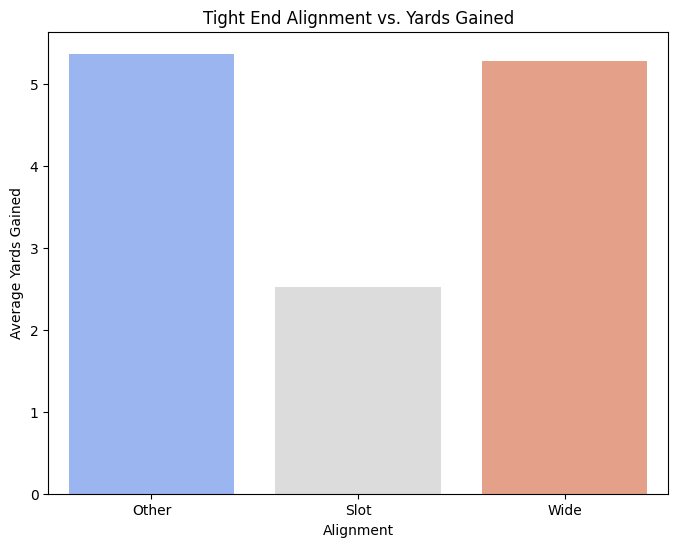

In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze success rates and yardage by alignment
te_alignment = te_data.groupby('alignment').agg({
    'yardsGained': 'mean',  # Average yards gained
    'playId': 'count'  # Number of plays
}).rename(columns={'playId': 'TotalPlays', 'yardsGained': 'AvgYardsGained'}).reset_index()

print("Impact of Alignment on Yards Gained:")
print(te_alignment)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(data=te_alignment, x='alignment', y='AvgYardsGained', palette='coolwarm')
plt.title('Tight End Alignment vs. Yards Gained')
plt.xlabel('Alignment')
plt.ylabel('Average Yards Gained')
plt.show()

Tight End Impact on Run vs Pass Plays:
  alignment  isDropback  AvgYardsGained  TotalPlays PlayType
0     Other       False        3.962047        4084      Run
1     Other        True        6.263199        6402     Pass
2      Slot       False        2.816901          71      Run
3      Slot        True        1.000000          14     Pass
4      Wide       False        4.316057        5113      Run
5      Wide        True        6.198607        5312     Pass


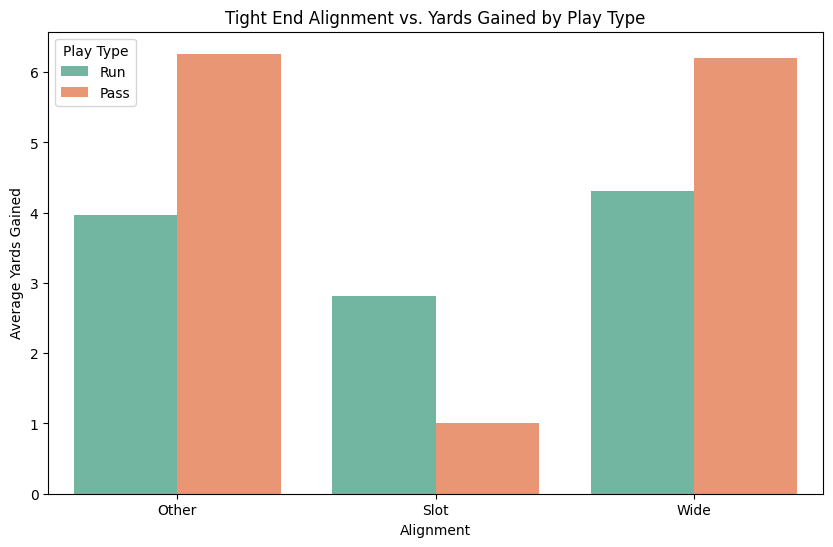

In [11]:
# Analyze TE involvement in run vs pass plays
te_run_pass = te_data.groupby(['alignment', 'isDropback']).agg({
    'yardsGained': 'mean',  # Average yards gained
    'playId': 'count'  # Number of plays
}).rename(columns={'playId': 'TotalPlays', 'yardsGained': 'AvgYardsGained'}).reset_index()

# Replace isDropback values with labels (0 = Run, 1 = Pass)
te_run_pass['PlayType'] = te_run_pass['isDropback'].apply(lambda x: 'Pass' if x == 1 else 'Run')

print("Tight End Impact on Run vs Pass Plays:")
print(te_run_pass)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=te_run_pass, x='alignment', y='AvgYardsGained', hue='PlayType', palette='Set2')
plt.title('Tight End Alignment vs. Yards Gained by Play Type')
plt.xlabel('Alignment')
plt.ylabel('Average Yards Gained')
plt.legend(title='Play Type')
plt.show()

In [14]:
import pandas as pd

# Load datasets
players_2 = pd.read_csv('nfl-big-data-bowl-2025/players.csv')  # Player-level information
player_play_2 = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')  # Player stats for each play
plays_2 = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')  # Play-level data

# Filter for tight ends (position = 'TE') from players dataset
te_players = players_2[players_2['position'] == 'TE']

# Merge tight end player data with player_play and plays
te_data = player_play_2.merge(te_players, on='nflId').merge(plays_2, on=['gameId', 'playId'])

# Identify inactive players
inactive_condition = (
    (te_data['wasRunningRoute'].isna() | (te_data['wasRunningRoute'] == False)) &
    (te_data['pressureAllowedAsBlocker'].isna() | (te_data['pressureAllowedAsBlocker'] == 0)) &
    te_data['blockedPlayerNFLId1'].isna() &
    te_data['blockedPlayerNFLId2'].isna() &
    te_data['blockedPlayerNFLId3'].isna() &
    (te_data['inMotionAtBallSnap'].isna() | (te_data['inMotionAtBallSnap'] == False))
)

# Filter out inactive rows
active_te_data = te_data[~inactive_condition]

print(f"Number of rows removed as inactive: {len(te_data) - len(active_te_data)}")
print(f"Remaining active rows: {len(active_te_data)}")

# Save the filtered active_te_data to a CSV file
output_file_path = "active_te_data.csv"  # You can specify a different path if needed

active_te_data.to_csv(output_file_path, index=False)

print(f"Filtered tight end data (without inactive players) saved successfully to {output_file_path}")

# Apply categorization for alignment on active players only
def categorize_alignment(alignment):
    if alignment == '0x0':  # Inline alignment
        return 'Inline'
    elif alignment in ['1x0', '2x0']:  # Slot alignment
        return 'Slot'
    elif alignment in ['1x1', '2x1', '3x1']:  # Wide alignment
        return 'Wide'
    else:
        return 'Other'

def determine_te_action(row):
    # Case 1: Blocking
    # Check if `wasRunningRoute` is NaN and blocking ID is not NaN
    if pd.isna(row['wasRunningRoute']) and pd.notna(row['pressureAllowedAsBlocker']):
        return 'Blocker'
     # Check if running a route but not blocking
    elif pd.notna(row['wasRunningRoute']) and pd.isna(row['pressureAllowedAsBlocker']):
        return 'Route Runner'
    # Check if they are doing a chip and release
    elif pd.notna(row['wasRunningRoute']) and pd.notna(row['pressureAllowedAsBlocker']):
        return 'Chip & Release'
    # Catch-all for others
    elif pd.notna(row['inMotionAtBallSnap']):
        return 'Decoy'
    else:
        return 'Other'

# Create a copy of the filtered DataFrame
active_te_data = active_te_data.copy()

# Proceed with assignments
active_te_data['alignment'] = active_te_data['receiverAlignment'].apply(categorize_alignment)
active_te_data['te_action'] = active_te_data.apply(determine_te_action, axis=1)

print("TE Action Distribution After Filtering:\n", active_te_data['te_action'].value_counts())

Number of rows removed as inactive: 9639
Remaining active rows: 11357
Filtered tight end data (without inactive players) saved successfully to active_te_data.csv
TE Action Distribution After Filtering:
 te_action
Route Runner      8986
Blocker           1283
Chip & Release     589
Decoy              499
Name: count, dtype: int64


In [15]:
# Ensure that the DataFrame `te_data` exists with the processed data
# Save the DataFrame to a CSV file
output_file_path = "active_te_data.csv"  # Specify your desired file path

# Export te_data to a CSV file
active_te_data.to_csv(output_file_path, index=False)

print(f"Tight end data saved successfully to {output_file_path}")

Tight end data saved successfully to active_te_data.csv


/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/4090212866.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=te_action_distribution.index, y=te_action_distribution.values, palette='viridis')


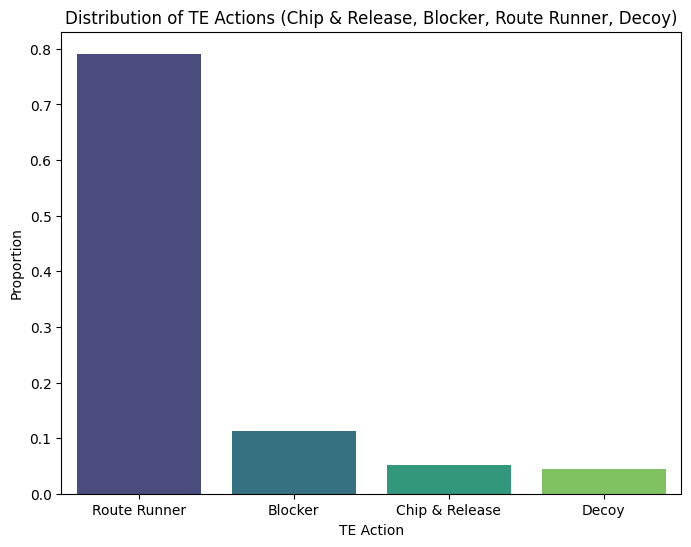

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

te_action_distribution = active_te_data['te_action'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=te_action_distribution.index, y=te_action_distribution.values, palette='viridis')
plt.title('Distribution of TE Actions (Chip & Release, Blocker, Route Runner, Decoy)')
plt.xlabel('TE Action')
plt.ylabel('Proportion')
plt.show()